In [107]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
json_filename = 'configs/config_sononet_8_andi.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]

In [118]:
us_data['label_names'].value[cardiac_classes]

array([b'3VV', b'4CH', b'LVOT', b'RVOT'], dtype='|S16')

In [5]:
card_train_id = np.array([i in cardiac_classes for i in us_data['plane_labels_train'].value])
card_test_id = np.array([i in cardiac_classes for i in us_data['plane_labels_test'].value])

In [6]:
card_images_train = torch.tensor(us_data['images_train'][card_train_id,:,:,:])
card_labels_train = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_train'][card_train_id]])

card_images_test = torch.tensor(us_data['images_test'][card_test_id,:,:,:])
card_labels_test = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_test'][card_test_id]])

In [7]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [8]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [9]:
train_dataset = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (card_images_test, card_labels_test),
        transform=ds_transform['valid'])

In [58]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [59]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, batch_size)

In [60]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [67]:
def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))

In [62]:
model.set_labels([0,1,2,3])
model.set_scheduler(train_opts)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)


In [70]:
for epoch in tqdm(range(100)):
    print('x')
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if (epoch + 1) % 20 == 0:
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

        #model.update_learning_rate(metric=valid_err, epoch=epoch)


  0%|          | 0/100 [00:00<?, ?it/s]x

  1%|          | 1/100 [00:00<00:20,  4.83it/s]x

  2%|▏         | 2/100 [00:00<00:21,  4.65it/s]x

  3%|▎         | 3/100 [00:00<00:20,  4.65it/s]x

  4%|▍         | 4/100 [00:00<00:20,  4.72it/s]x

  5%|▌         | 5/100 [00:01<00:20,  4.75it/s]
x
  6%|▌         | 6/100 [00:01<00:19,  4.81it/s]
x
  7%|▋         | 7/100 [00:01<00:19,  4.78it/s]x

  8%|▊         | 8/100 [00:01<00:19,  4.81it/s]x

  9%|▉         | 9/100 [00:01<00:19,  4.79it/s]
x
 10%|█         | 10/100 [00:02<00:18,  4.86it/s]x

 11%|█         | 11/100 [00:02<00:18,  4.82it/s]x

 12%|█▏        | 12/100 [00:02<00:18,  4.84it/s]
x
 13%|█▎        | 13/100 [00:02<00:17,  4.89it/s]x

 14%|█▍        | 14/100 [00:02<00:17,  4.85it/s]x

 15%|█▌        | 15/100 [00:03<00:17,  4.79it/s]x

 16%|█▌        | 16/100 [00:03<00:17,  4.77it/s]x

 17%|█▋        | 17/100 [00:03<00:17,  4.71it/s]x

 18%|█▊        | 18/100 [00:03<00:17,  4.70it/s]x

 19%|█▉        | 19/100 [00:03<00:17,  4.72it/s]

In [73]:
print_accuracy(model, 'test')

Accuracy test: 0.5963060855865479


In [98]:
def get_logits(model, fold):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            logits.append(model.logits.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [99]:
foo, bar = get_logits(model, 'train')

In [87]:
from ptsne.ptsne import ParametricTSNE

In [100]:
ptsne = ParametricTSNE(4, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)

In [101]:
ptsne.fit(foo, pretrain=True, verbose=True)

Calculating PCA
2020-03-11 14:46:51.486636: Beginning pretraining for 5 epochs
2020-03-11 14:46:51.915633: Loss after epoch 0: 13.875383898615837
2020-03-11 14:46:51.962635: Loss after epoch 1: 0.33989033102989197
2020-03-11 14:46:52.020632: Loss after epoch 2: 0.313346728682518
2020-03-11 14:46:52.054633: Loss after epoch 3: 0.1750459149479866
2020-03-11 14:46:52.087631: Loss after epoch 4: 0.14431966468691826
2020-03-11 14:46:52.088633: Finished pretraining
Indexing
2020-03-11 14:46:57.202850: Beginning training for 10 epochs
2020-03-11 14:46:57.302852: Loss after epoch 1: 14.142416228760634
2020-03-11 14:46:57.406849: Loss after epoch 2: 12.935341615649161
2020-03-11 14:46:57.515850: Loss after epoch 3: 9.077522645516048
2020-03-11 14:46:57.625851: Loss after epoch 4: 6.235513745906937
2020-03-11 14:46:57.736850: Loss after epoch 5: 5.741356239502878
2020-03-11 14:46:57.835850: Loss after epoch 6: 5.862622099516999
2020-03-11 14:46:57.940851: Loss after epoch 7: 5.998966046352228
20

In [104]:
projected = ptsne(foo.cuda()).cpu().detach()

In [105]:
projected

tensor([[-50.7660, 103.5325],
        [-54.8288, 100.5907],
        [-59.6146,  98.3180],
        ...,
        [-53.2348, 102.3240],
        [-52.9717, 102.1017],
        [-18.1194, 134.9146]])

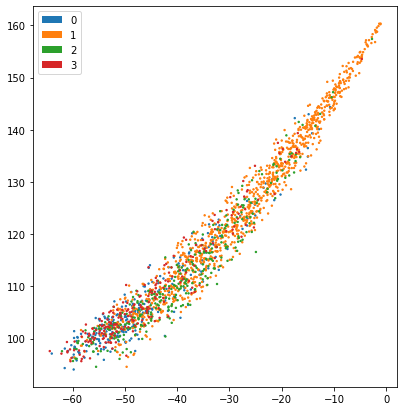

In [109]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in bar]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [114]:
foo.argmax(dim=1)[:100]

tensor([0, 3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 1, 3, 0, 0, 3, 1, 3, 0, 2, 0, 2, 3, 1,
        2, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1, 3, 3, 3, 1, 2,
        3, 1, 0, 0, 2, 0, 0, 3, 1, 0, 1, 1, 3, 3, 0, 3, 3, 0, 0, 1, 1, 1, 3, 1,
        3, 0, 3, 0, 0, 1, 3, 3, 3, 1, 0, 0, 1, 0, 1, 1, 1, 3, 1, 0, 3, 0, 2, 3,
        1, 3, 3, 0])

In [115]:
bar[:100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])